In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

In [2]:
import sklearn.feature_selection

# Irrelevant features and feature importances

Not all descriptive features are equally important in all situations.

In the following example we create an artificial dataset with 6 dimensions.
We also create a target function that depends on the first two features only.

In [3]:
# Features
nn = 2000 # number of points
dd = 6 # number of features
data = np.random.uniform(size=[nn,dd], low=-4, high=4)

target = 10 * np.cos(np.pi * 0.2 * (data[:,0] + data[:,1])) + 3 * np.cos(
    np.pi * 1 * (data[:,0] - data[:,1]))


Here we can see the data points in the first two dimensions colored with the target

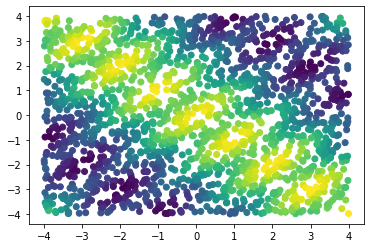

In [4]:
fig, ax = plt.subplots()

ax.scatter(data[:, 0], data[:, 1], c=target)

Here we can see the data points scatterd against the target for each feature

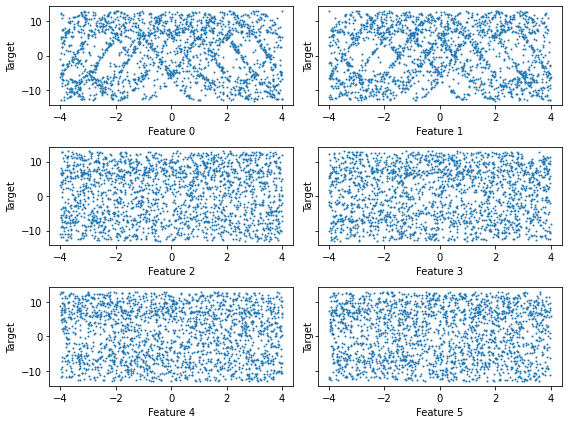

In [5]:
fig, axes = plt.subplots(ncols=2,nrows=3, figsize=[8,6], sharey=True)
axes = axes.ravel()
for i in range(len(axes)):
    axes[i].scatter(data[:, i], target, s=1)
    axes[i].set_xlabel('Feature {}'.format(i))
    axes[i].set_ylabel('Target')
plt.tight_layout()
plt.show()

Methods that use "similarity" to compare data points will fail in this dataset, as similarity will be polluted by noisy irrelevant features.

For example, similarity measures that depend on the Euclidean metric, e.g. a gaussian kernel ($k(x_1, x_2) = e^{- 
\gamma d(x_1, x_2)^2}$) will depend on features that have zero relevance for the prediction of the target values.

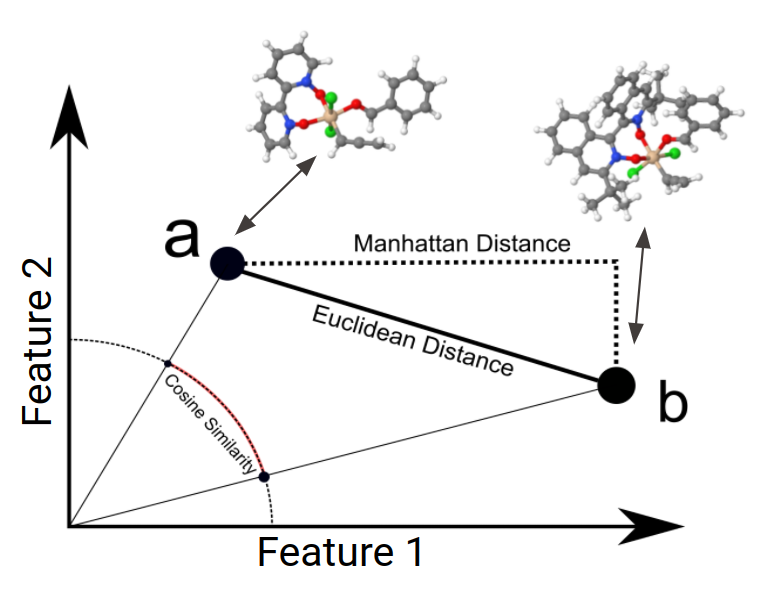

The Euclidean distance between points $x_1$ and $x_2$ ($ d(x_1, x_2) = \sqrt{\sum_i (x_1^i - x_2^i)^2} $) is statistically dominated by the features that have the highest variance in a particular dataset. In the artificial dataset, all features have the same variance, so they all contribute equally to the Euclidean distance.

Text(0, 0.5, 'Variance')

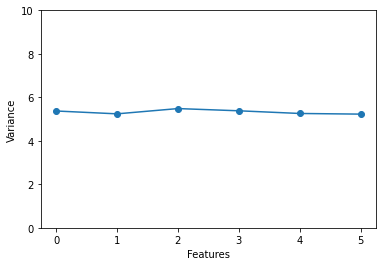

In [14]:
fig, ax = plt.subplots()

ax.plot(data.var(axis=0), marker='o')
ax.set_ylim(0, 10)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')

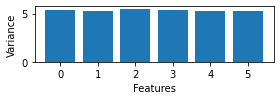

In [32]:
fig, ax = plt.subplots(figsize=[4,1.5])

ax.bar(np.arange(data.shape[1]), data.var(axis=0))

# ax.bar(np.arange(data.shape[1]), data.var(axis=0))

ax.set_xticks([0,1,2,3,4,5])
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
plt.tight_layout()
plt.savefig('vts_1.pdf')
plt.show()

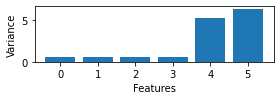

In [33]:
fig, ax = plt.subplots(figsize=[4,1.5])

ax.bar(np.arange(data.shape[1]), data.var(axis=0) * np.array([0.1,0.1,0.1,0.1,1, 1.2]))

# ax.bar(np.arange(data.shape[1]), data.var(axis=0))

ax.set_xticks([0,1,2,3,4,5])
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
plt.tight_layout()
plt.savefig('vts_2.pdf')

plt.show()

Filter irrelevant features for linear problems can easily be done using sparse regression techniques such as OMP. For problems where the target values is nonlinearly related to the features there are less straightforwards methods.

A straightforward possibility is to use a mutual information regression between each feature and the target property. This gives an idea of the relevance of each feature for this particular problem.

In [7]:
inf = sk.feature_selection.mutual_info_regression(data, target)

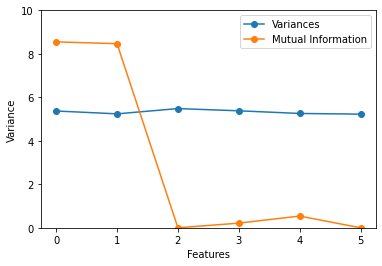

In [8]:
fig, ax = plt.subplots()

ax.plot(data.var(axis=0), marker='o', label='Variances')
ax.plot(inf * 30, marker='o', label='Mutual Information')
ax.set_ylim(0, 10)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.legend()
plt.show()

This clearly shows that the first two features have a higher mutual information than the rest.

We can naively transform the original feature space so that the variances match the Mutual Information.

In [9]:
data_mi = sk.preprocessing.StandardScaler().fit_transform(data)
data_mi *= np.sqrt(30 * inf)

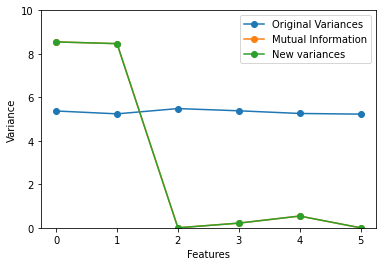

In [10]:
fig, ax = plt.subplots()

ax.plot(data.var(axis=0), marker='o', label='Original Variances')
ax.plot(inf * 30, marker='o', label='Mutual Information')
ax.plot(data_mi.var(axis=0), marker='o', label='New variances')

ax.set_ylim(0, 10)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.legend()
plt.show()

This new scaled features in principle should provide a better similarity than the original features. We can visualize this using dissimilarity plots.

Dissimilarity plots compare the metric between two points and the difference between their target values. A good metric will show that the difference between target values will go to zero as the feature distance goes to zero.

In [11]:
distance_matrix_original = sk.metrics.pairwise.pairwise_distances(data, n_jobs=-1)
distance_matrix_mi = sk.metrics.pairwise.pairwise_distances(data_mi, n_jobs=-1)

target_diff_matrix = np.subtract.outer(target, target)

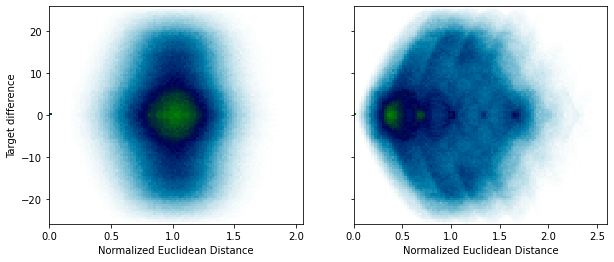

In [12]:
fig, axes = plt.subplots(figsize=[10,4], ncols=2, sharey=True)

ax = axes[0]
mm = distance_matrix_original.ravel() / distance_matrix_original.mean()
ax.hist2d(mm.ravel(), target_diff_matrix.ravel(), bins=100, cmap='ocean_r')
ax.set_ylabel('Target difference')
ax.set_xlabel('Normalized Euclidean Distance')


ax = axes[1]
mm = distance_matrix_mi.ravel() / distance_matrix_mi.mean()
ax.hist2d(mm.ravel(), target_diff_matrix.ravel(), bins=100, cmap='ocean_r')
ax.set_xlabel('Normalized Euclidean Distance')

# ax.set_yticks([-5,0,5])
plt.show()

The dissimilarity plot of the modified feature space has a better behaviour. The improved similarity measure will have an effect on any similarity based supervised or unsupervised algorithm, such as K-Nearest Neighbours, PCA or t-SNE.

In [13]:
indices_train, indices_test = sk.model_selection.train_test_split(
        np.arange(len(data)), train_size=0.7, test_size=0.3, random_state=0)

In [14]:
knn1 = sk.neighbors.KNeighborsRegressor()
knn1.fit(data[indices_train], target[indices_train])
predictions1 = np.array(knn1.predict(data[indices_test]))

In [15]:
knn2 = sk.neighbors.KNeighborsRegressor()
knn2.fit(data_mi[indices_train], target[indices_train])
predictions2 = np.array(knn2.predict(data_mi[indices_test]))

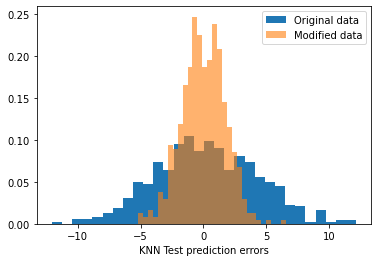

In [16]:
fig, ax = plt.subplots()

ax.hist(predictions1 - target[indices_test], bins=30, density=True, label='Original data')
ax.hist(predictions2 - target[indices_test], bins=30, density=True, alpha=0.6, label='Modified data')
ax.legend()
ax.set_xlabel('KNN Test prediction errors')
plt.show()

In [17]:
pca1 = sk.decomposition.PCA(n_components=2).fit_transform(data)
pca2 = sk.decomposition.PCA(n_components=2).fit_transform(data_mi)

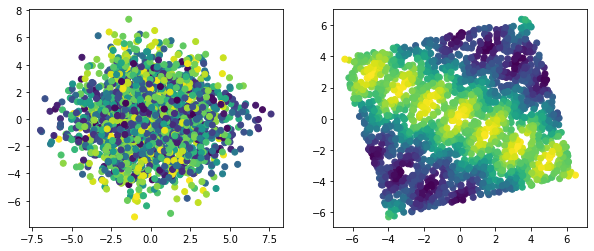

In [18]:
fig, axes = plt.subplots(figsize=[10,4], ncols=2)
axes[0].scatter(pca1[:, 0], pca1[:, 1], c=target)
axes[1].scatter(pca2[:, 0], pca2[:, 1], c=target)
plt.show()